In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# hyperparameters
learning_rate = 0.001
epochs = 30
batch_size = 128
num_classes = 2    # 0: cat, 1: dog

In [4]:
# define transforms for training data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(),
    transforms.Normalize((0.5,), (0.5,))
])

# define transforms for validation data
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
# load data
train_dataset = torchvision.datasets.ImageFolder(root='./dataset/training_dataset', transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root='./dataset/validation_dataset', transform=val_transform)

# data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
print(f'Classes: {train_dataset.classes}')
print(f'Class to idx: {train_dataset.class_to_idx}')

Classes: ['Cat', 'Dog']
Class to idx: {'Cat': 0, 'Dog': 1}


In [7]:
print(len(train_loader))

127


In [8]:
# load pretrained model ResNet50
model = torchvision.models.resnet50(pretrained=True)
# change the last layer to fit our task (classes = 2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
# move model to device
model.to(device)

/home/nckusoc/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nckusoc/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# record loss and accuracy
train_loss, train_acc = [], []
val_loss, val_acc = [], []

In [11]:
# train the model

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1:2d}/{epochs:2d}')
    # training
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == labels.data).item() / images.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # validation
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            # record loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_acc += torch.sum(preds == labels.data).item() / images.size(0)
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = running_acc / len(val_loader)
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

    print(f'Epoch {epoch+1:2d} | Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}')


Epoch  1/30


 37%|███▋      | 47/127 [00:22<00:37,  2.15it/s]/home/nckusoc/miniconda3/envs/cv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch  1 | Train Loss: 0.2432 | Train Acc: 0.8971 | Val Loss: 0.2411 | Val Acc: 0.8969

Epoch  2/30


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch  2 | Train Loss: 0.1618 | Train Acc: 0.9322 | Val Loss: 0.1854 | Val Acc: 0.9323

Epoch  3/30


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


Epoch  3 | Train Loss: 0.1443 | Train Acc: 0.9402 | Val Loss: 0.1200 | Val Acc: 0.9521

Epoch  4/30


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch  4 | Train Loss: 0.1338 | Train Acc: 0.9468 | Val Loss: 0.0905 | Val Acc: 0.9661

Epoch  5/30


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Epoch  5 | Train Loss: 0.1222 | Train Acc: 0.9502 | Val Loss: 0.1149 | Val Acc: 0.9599

Epoch  6/30


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Epoch  6 | Train Loss: 0.1159 | Train Acc: 0.9536 | Val Loss: 0.1099 | Val Acc: 0.9573

Epoch  7/30


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Epoch  7 | Train Loss: 0.1023 | Train Acc: 0.9585 | Val Loss: 0.1410 | Val Acc: 0.9583

Epoch  8/30


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Epoch  8 | Train Loss: 0.1098 | Train Acc: 0.9559 | Val Loss: 0.1428 | Val Acc: 0.9375

Epoch  9/30


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Epoch  9 | Train Loss: 0.0921 | Train Acc: 0.9636 | Val Loss: 0.1149 | Val Acc: 0.9547

Epoch 10/30


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Epoch 10 | Train Loss: 0.0919 | Train Acc: 0.9628 | Val Loss: 0.1476 | Val Acc: 0.9417

Epoch 11/30


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


Epoch 11 | Train Loss: 0.0881 | Train Acc: 0.9655 | Val Loss: 0.1021 | Val Acc: 0.9578

Epoch 12/30


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Epoch 12 | Train Loss: 0.0870 | Train Acc: 0.9656 | Val Loss: 0.1500 | Val Acc: 0.9474

Epoch 13/30


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Epoch 13 | Train Loss: 0.0857 | Train Acc: 0.9663 | Val Loss: 0.1060 | Val Acc: 0.9594

Epoch 14/30


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 14 | Train Loss: 0.0812 | Train Acc: 0.9669 | Val Loss: 0.0841 | Val Acc: 0.9724

Epoch 15/30


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Epoch 15 | Train Loss: 0.0790 | Train Acc: 0.9687 | Val Loss: 0.0954 | Val Acc: 0.9604

Epoch 16/30


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 16 | Train Loss: 0.0700 | Train Acc: 0.9709 | Val Loss: 0.0880 | Val Acc: 0.9760

Epoch 17/30


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


Epoch 17 | Train Loss: 0.0716 | Train Acc: 0.9714 | Val Loss: 0.1142 | Val Acc: 0.9599

Epoch 18/30


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Epoch 18 | Train Loss: 0.0774 | Train Acc: 0.9690 | Val Loss: 0.2156 | Val Acc: 0.9135

Epoch 19/30


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 19 | Train Loss: 0.0646 | Train Acc: 0.9749 | Val Loss: 0.1770 | Val Acc: 0.9307

Epoch 20/30


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 20 | Train Loss: 0.0728 | Train Acc: 0.9712 | Val Loss: 0.0991 | Val Acc: 0.9609

Epoch 21/30


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch 21 | Train Loss: 0.0652 | Train Acc: 0.9749 | Val Loss: 0.0656 | Val Acc: 0.9750

Epoch 22/30


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch 22 | Train Loss: 0.0615 | Train Acc: 0.9763 | Val Loss: 0.0871 | Val Acc: 0.9688

Epoch 23/30


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch 23 | Train Loss: 0.0582 | Train Acc: 0.9759 | Val Loss: 0.1303 | Val Acc: 0.9464

Epoch 24/30


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch 24 | Train Loss: 0.0636 | Train Acc: 0.9763 | Val Loss: 0.0672 | Val Acc: 0.9755

Epoch 25/30


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 25 | Train Loss: 0.0557 | Train Acc: 0.9792 | Val Loss: 0.1722 | Val Acc: 0.9391

Epoch 26/30


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 26 | Train Loss: 0.0554 | Train Acc: 0.9777 | Val Loss: 0.0880 | Val Acc: 0.9667

Epoch 27/30


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 27 | Train Loss: 0.0601 | Train Acc: 0.9783 | Val Loss: 0.0833 | Val Acc: 0.9729

Epoch 28/30


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch 28 | Train Loss: 0.0613 | Train Acc: 0.9762 | Val Loss: 0.0710 | Val Acc: 0.9703

Epoch 29/30


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 29 | Train Loss: 0.0558 | Train Acc: 0.9777 | Val Loss: 0.0794 | Val Acc: 0.9656

Epoch 30/30


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]

Epoch 30 | Train Loss: 0.0585 | Train Acc: 0.9764 | Val Loss: 0.0766 | Val Acc: 0.9724


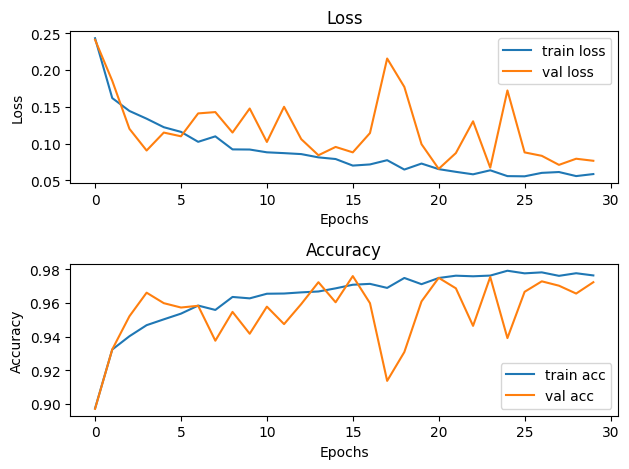

In [12]:
# plot loss and accuracy
plt.figure()
# loss
plt.subplot(2,1,1)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
# accuracy
plt.subplot(2,1,2)
plt.plot(train_acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
# save figure
plt.tight_layout()
plt.savefig('cat_dog_resnet50_re.png')
plt.show()

In [13]:
# save model
torch.save(model.state_dict(), 'cat_dog_resnet50_re.pth')